## Group 12

Rita Palma 20240661 <br>
Santiago Taylor 20240542 <br>
Martim Tavares 20240508 <br>
Maria Inês Assunção 20211605 <br>

# Library imports

In [ ]:
!pip install keras_tuner
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.8 MB/s eta 0:00:00


In [ ]:
# python standard library imports
from typing import Self, Any
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import os
from tqdm import tqdm


# plots and graphs
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import image_dataset_from_directory
from sklearn.utils import class_weight, resample
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models

# augmentation operations
from keras.layers import Rescaling, RandomBrightness, RandomFlip, RandomRotation, RandomZoom, RandAugment, RandomGrayscale, RandomSharpness
from keras_cv.layers import RandomGaussianBlur, RandomCutout, AugMix
from keras.layers import Pipeline

# model building imports
from keras import Model, Sequential, Input
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from keras.ops import add
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import LearningRateScheduler, CSVLogger, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt
import tensorflow as tf
import keras_cv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir_path = Path("/content/drive/My Drive/DL_project/DL_project")

In [ ]:
df = pd.read_csv(root_dir_path / "rare_species/metadata.csv")

# Load Data

In [ ]:
data_dir_path = root_dir_path / "data"

train_dir_path = data_dir_path / "train"
val_dir_path = data_dir_path / "val"
test_dir_path = data_dir_path / "test"

In [ ]:
n_classes = 202
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    verbose=False
)

In [ ]:
val_ds = image_dataset_from_directory(
    val_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

In [ ]:
test_ds = image_dataset_from_directory(
    test_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

# Normalizing Images


In [ ]:
# Normalize pixel valuse to the range [0, 1]
rescaler =  Rescaling(scale=1 / 255.0)

train_ds = train_ds.map(lambda x, y: (rescaler(x), y))
val_ds = val_ds.map(lambda x, y: (rescaler(x), y))
test_ds = test_ds.map(lambda x, y: (rescaler(x), y))

# Data Preprocessing

In [ ]:
# take a sample of training to improve generalization
train_ds_sample = image_dataset_from_directory(
    train_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    # doing this to only use 80% of our data
    validation_split=0.2,
    subset="training",
    seed=123,
    verbose=False
)


Using 6712 files for training.


In [ ]:
train_ds_sample = train_ds_sample.map(lambda x, y: (rescaler(x), y))

### Apply augmentations

In [ ]:
# combo 1 - best augmentation approach -> BRIGHTNESS + FLIP + ZOOM + CUTOUT
augmentation_combination_1 = Pipeline(
    [
        RandomBrightness(factor=0.2, value_range=value_range),
        RandomFlip(mode="horizontal"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomCutout(height_factor=0.5, width_factor=0.5),
    ],
    name="Brightness-Flip-Zoom-Cutout"
)

In [ ]:
# combo 2 - best augmentation approach -> CUTOUT + GRAYSCALE + FLIP + BLUR
'''augmentation_combination_2 = Pipeline(
    [
        RandomCutout(height_factor=0.5, width_factor=0.5),
        RandomGrayscale(factor=0.5),
        RandomFlip(mode="horizontal"),
        RandomGaussianBlur(factor=0.7, kernel_size=3),
    ],
    name="Cutout-Grayscale-Flip-Blur"
)'''

In [ ]:
# applying combo 1 transformation to images
train_ds_sample_aug = train_ds_sample.map(lambda x, y: (augmentation_combination_1(x, training= True), y))

In [ ]:
# applying combo 2 transformation to images
# train_ds_sample_aug_2 = train_ds_sample.map(lambda x, y: (augmentation_combination_2(x, training= True), y))

<div class="alert alert-block alert-info"> 

#  MODELING 
</div>

<div class="alert alert-block alert-info"> 

# DESIGNED MODELS

</div>

# BASIC CNN

In [ ]:
# build model

model = Sequential(
    layers = [
        Input(shape=input_shape),

        # block 1
        Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu",
            kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # block 2
        Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu",
            kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # finish and dropout
        Flatten(),
        Dropout(0.5),
        Dense(n_classes, activation="softmax")
    ],
    name="model_1"
)

# compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

epochs = 10

history = model.fit(
    train_ds_sample_aug,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

eval_results = model.evaluate(test_ds, return_dict=True, verbose=0)
print(f"Test loss: {eval_results['loss']}, Test accuracy: {eval_results['accuracy']}")

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3726s 35s/step - accuracy: 0.0133 - auc: 0.5070 - f1_score: 0.0078 - loss: 48.5436 - val_accuracy: 0.0095 - val_auc: 0.5041 - val_f1_score: 0.0026 - val_loss: 39.5658
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.0160 - auc: 0.5084 - f1_score: 0.0108 - loss: 57.3999 - val_accuracy: 0.0050 - val_auc: 0.5033 - val_f1_score: 6.1721e-04 - val_loss: 66.6731
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.0240 - auc: 0.5149 - f1_score: 0.0166 - loss: 43.1412 - val_accuracy: 0.0111 - val_auc: 0.5034 - val_f1_score: 2.3054e-04 - val_loss: 93.3734
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.0306 - auc: 0.5245 - f1_score: 0.0222 - loss: 30.9202 - val_accuracy: 0.0056 - val_auc: 0.5025 - val_f1_score: 0.0020 - val_loss: 59.6430
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.0437 - auc: 0.5373 - f1_score: 0.0360 - loss: 19.4946 - val_accuracy: 0.0028 - val_auc: 0.4975 - val_f1

# PARALLEL CNN

In [ ]:
def exp_decay_lr_scheduler(epoch: int, current_lr: float, factor: float = 0.95) -> float:
    """
    Exponential decay learning rate scheduler
    """
    current_lr *= factor
    return current_lr

In [ ]:
def model_parallel_conv():

    conv_layer_1 = Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu")
    max_pool_layer_1 = MaxPooling2D(pool_size=(2, 2))

    # parallel convolutional layers
    conv_layer_2l = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")
    conv_layer_2r = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")

    act_layer_2 = LeakyReLU(negative_slope=0.3)
    max_pool_layer_2 = MaxPooling2D(pool_size=(2, 2))

    flatten_layer = Flatten()

    dropout_layer = Dropout(rate=0.3)

    dense_layer = Dense(n_classes,activation="softmax")

    # defines input layer of the model
    inputs = Input(shape=input_shape)
    x = inputs

    x = conv_layer_1(x)
    x = max_pool_layer_1(x)

    x_l = conv_layer_2l(x)
    x_r = conv_layer_2r(x)
    x = add(x_l, x_r)

    x = act_layer_2(x)
    x = max_pool_layer_2(x)

    x = flatten_layer(x)
    x = dropout_layer(x)
    x = dense_layer(x)

    # final output of the model
    outputs = x

    # constructs a keras model object by specifying the input and output tensors
    return Model(inputs=inputs, outputs=outputs, name="model_parallel_conv")

In [ ]:
# model with combination 1

model_paral_aug1 = model_parallel_conv()

optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model_paral_aug1.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# CALLBACKS
# early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True)

# learning rate
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

# logging
metrics_file_path = root_dir_path / "Model Metrics"/ "model_paral_aug1.csv"
metrics_callback = CSVLogger(metrics_file_path)

callbacks = [early_stopping_callback, lr_scheduler_callback, metrics_callback]

epochs = 20

_ = model_paral_aug1.fit(
    train_ds_sample_aug,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.0026 - auc: 0.4792 - f1_score: 8.9448e-04 - loss: 5.4371 - val_accuracy: 0.0028 - val_auc: 0.5096 - val_f1_score: 2.9766e-04 - val_loss: 5.3094 - learning_rate: 0.0095
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.0045 - auc: 0.5178 - f1_score: 7.2878e-04 - loss: 5.3536 - val_accuracy: 0.0033 - val_auc: 0.5148 - val_f1_score: 3.3226e-04 - val_loss: 5.3221 - learning_rate: 0.0090
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.0062 - auc: 0.5274 - f1_score: 0.0017 - loss: 5.3510 - val_accuracy: 0.0045 - val_auc: 0.5142 - val_f1_score: 7.1437e-04 - val_loss: 5.3461 - learning_rate: 0.0086
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.0098 - auc: 0.5254 - f1_score: 0.0014 - loss: 5.3339 - val_accuracy: 0.0056 - val_auc: 0.5173 - val_f1_score: 5.4483e-04 - val_loss: 5.3589 - learning_rate: 0.0081
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.0

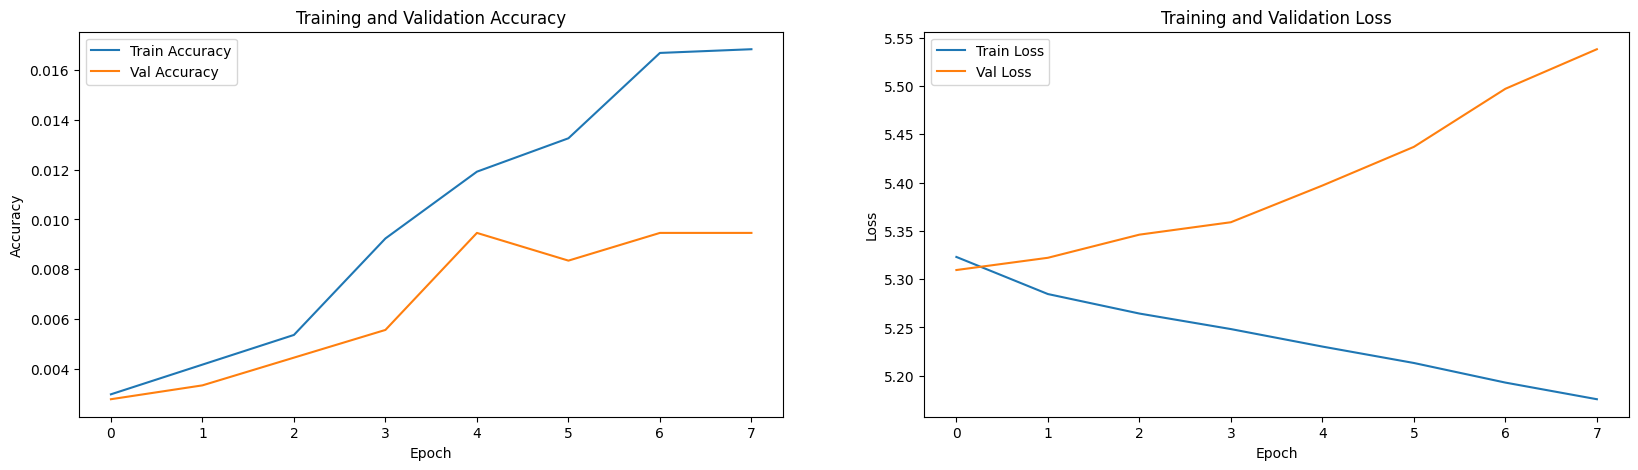

In [ ]:
df_aug = pd.read_csv(root_dir_path / "Model Metrics"/ "model_paral_aug1.csv")

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(df_aug["accuracy"], label="Train Accuracy")
axes[0].plot(df_aug["val_accuracy"], label="Val Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].plot(df_aug["loss"], label="Train Loss")
axes[1].plot(df_aug["val_loss"], label="Val Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

### Try same model but with oversampling the minority classes

In [ ]:
oversample_dir_path = data_dir_path / "train_oversampled"

'''
oversample_dir_path.mkdir(parents=True, exist_ok=True)

max_count = 90

# Oversample each class
for folder in os.listdir(train_dir_path):
    class_path = train_dir_path / folder
    images = os.listdir(class_path)

    # Make oversample class folder
    oversample_class_path = oversample_dir_path / folder
    oversample_class_path.mkdir(parents=True, exist_ok=True)

    # Copy original images
    for image in images:
        shutil.copy(class_path / image, oversample_class_path / image)

    # Duplicate as needed
    if len(images) < max_count:
        duplicate = resample(images, replace=True, n_samples=max_count - len(images), random_state=5)
        for i, image in enumerate(duplicate):
            shutil.copy(class_path / image, oversample_class_path / f"dup_{i}_{image}")
'''

In [ ]:
# take a sample of training oversample to improve generalization
train_ds_oversample = image_dataset_from_directory(
    oversample_dir_path,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    # doing this to only use 50% of our data
    validation_split=0.5,
    subset="training",
    seed=123,
    verbose=False
)

Using 9586 files for training.


In [ ]:
train_ds_oversample = train_ds_oversample.map(lambda x, y: (rescaler(x), y))

In [ ]:
def model_parallel_conv():

    augmentation_layer = augmentation_combination_1

    conv_layer_1 = Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu")
    max_pool_layer_1 = MaxPooling2D(pool_size=(2, 2))

    # parallel convolutional layers
    conv_layer_2l = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")
    conv_layer_2r = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")

    act_layer_2 = LeakyReLU(negative_slope=0.3)
    max_pool_layer_2 = MaxPooling2D(pool_size=(2, 2))

    flatten_layer = Flatten()

    dropout_layer = Dropout(rate=0.3)

    dense_layer = Dense(n_classes,activation="softmax")

    # defines input layer of the model
    inputs = Input(shape=input_shape)
    x = inputs

    x = augmentation_layer(x)

    x = conv_layer_1(x)
    x = max_pool_layer_1(x)

    x_l = conv_layer_2l(x)
    x_r = conv_layer_2r(x)
    x = add(x_l, x_r)

    x = act_layer_2(x)
    x = max_pool_layer_2(x)

    x = flatten_layer(x)
    x = dropout_layer(x)
    x = dense_layer(x)

    # final output of the model
    outputs = x

    return Model(inputs=inputs, outputs=outputs, name="model_parallel_conv")

In [ ]:
# model with combination 1

model_paral_aug1 = model_parallel_conv()

optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model_paral_aug1.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# CALLBACKS
# early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True)

# learning rate
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

# logging
metrics_file_path = root_dir_path / "Model Metrics"/ "model_oversample_paral_aug1.csv"
metrics_callback = CSVLogger(metrics_file_path)

callbacks = [early_stopping_callback, lr_scheduler_callback, metrics_callback]

epochs = 15

_ = model_paral_aug1.fit(
    train_ds_oversample,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1959s 13s/step - accuracy: 0.0128 - auc: 0.5339 - f1_score: 0.0025 - loss: 5.3077 - val_accuracy: 0.0540 - val_auc: 0.6386 - val_f1_score: 0.0038 - val_loss: 5.0813 - learning_rate: 0.0095
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1384s 9s/step - accuracy: 0.0323 - auc: 0.6239 - f1_score: 0.0093 - loss: 5.1253 - val_accuracy: 0.0551 - val_auc: 0.6624 - val_f1_score: 0.0173 - val_loss: 4.9920 - learning_rate: 0.0090
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1381s 9s/step - accuracy: 0.0578 - auc: 0.6857 - f1_score: 0.0272 - loss: 4.9407 - val_accuracy: 0.0590 - val_auc: 0.6869 - val_f1_score: 0.0179 - val_loss: 4.9141 - learning_rate: 0.0086
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1390s 9s/step - accuracy: 0.0764 - auc: 0.7244 - f1_score: 0.0439 - loss: 4.7829 - val_accuracy: 0.0573 - val_auc: 0.7002 - val_f1_score: 0.0229 - val_loss: 4.9079 - learning_rate: 0.0081
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1355s 9s/step - accuracy: 0.0919 - auc: 0.7556 

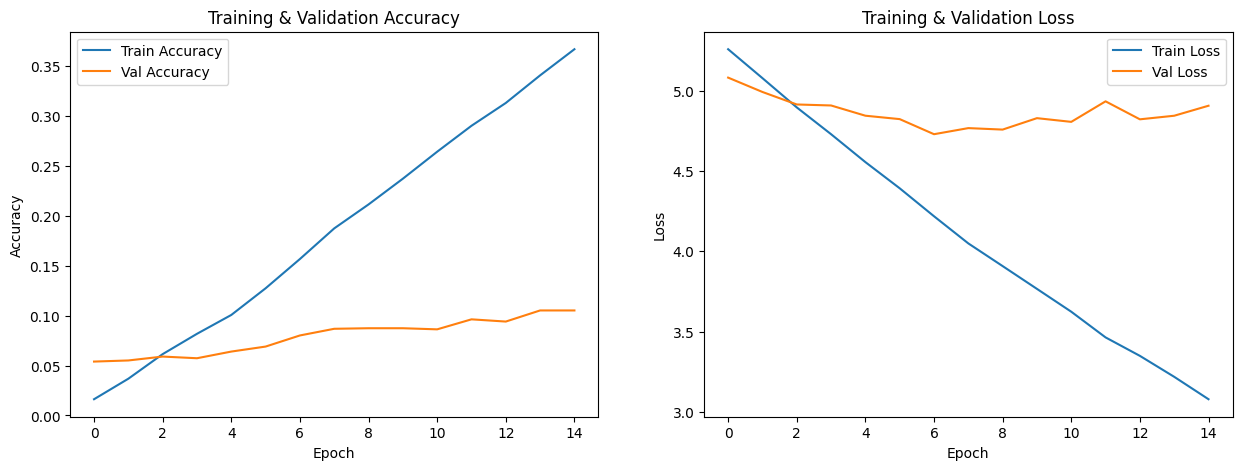

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy side by side
axes[0].plot(_.history["accuracy"], label="Train Accuracy")
axes[0].plot(_.history["val_accuracy"], label="Val Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Plot loss side by side
axes[1].plot(_.history["loss"], label="Train Loss")
axes[1].plot(_.history["val_loss"], label="Val Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

In [ ]:
model_paral_aug1.evaluate(
    test_ds,
    return_dict=True,
    verbose=0
)

{'accuracy': 0.1034482792019844,
 'auc': 0.7432038187980652,
 'f1_score': 0.07972206175327301,
 'loss': 4.818679332733154}

- model is failing to make correct predictions for a large number of classes

Steps to improve model:
1. More augmentations: add the two combinations together
2. Try label soothing
3. Add batch normalization after convolutional layers
4. Increase dropout

In [ ]:
augmentation_combination_3 = Pipeline(
    [
        RandomBrightness(factor=0.2, value_range=value_range),
        RandomFlip(mode="horizontal"),
        RandomZoom(height_factor=(0.0, 0.3), width_factor=(0.0, 0.3)),
        RandomCutout(height_factor=0.5, width_factor=0.5),
        RandomGrayscale(factor=0.5),
        RandomGaussianBlur(factor=0.7, kernel_size=3),
    ],
    name="Brightness-Flip-Zoom-Cutout-Grayscale-Blur"
)

In [ ]:
def model_parallel_conv3():

    augmentation_layer = augmentation_combination_3

    conv_layer_1 = Conv2D(filters=3 * 8, kernel_size=(3, 3), activation="relu")
    normaliation_layer_1 = BatchNormalization()
    max_pool_layer_1 = MaxPooling2D(pool_size=(2, 2))

    # parallel convolutional layers
    conv_layer_2l = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")
    conv_layer_2r = Conv2D(filters=3 * 16, kernel_size=(3, 3), activation="relu", padding="same")
    normaliation_layer_2 = BatchNormalization()

    act_layer_2 = LeakyReLU(negative_slope=0.3)
    max_pool_layer_2 = MaxPooling2D(pool_size=(2, 2))

    flatten_layer = Flatten()

    dropout_layer = Dropout(rate=0.5)

    dense_layer = Dense(n_classes,activation="softmax")

    # defines input layer of the model
    inputs = Input(shape=input_shape)
    x = inputs

    x = augmentation_layer(x)

    x = conv_layer_1(x)
    x = normaliation_layer_1(x)

    x = max_pool_layer_1(x)

    x_l = conv_layer_2l(x)
    x_r = conv_layer_2r(x)
    x = add(x_l, x_r)
    x = normaliation_layer_2(x)

    x = act_layer_2(x)
    x = max_pool_layer_2(x)

    x = flatten_layer(x)
    x = dropout_layer(x)
    x = dense_layer(x)

    # final output of the model
    outputs = x

    return Model(inputs=inputs, outputs=outputs, name="model_parallel_conv3")

In [ ]:
# model with combination 1

model_paral_aug3 = model_parallel_conv3()

optimizer = SGD(learning_rate=0.01, name="optimizer", weight_decay=0.01)
loss = CategoricalCrossentropy(label_smoothing=0.1, name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model_paral_aug3.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# CALLBACKS
# early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True)

# learning rate
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

# logging
metrics_file_path = root_dir_path / "Model Metrics"/ "model_oversample_paral_aug3.csv"
metrics_callback = CSVLogger(metrics_file_path)

callbacks = [early_stopping_callback, lr_scheduler_callback, metrics_callback]

epochs = 15

_3 = model_paral_aug3.fit(
    train_ds_oversample,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1942s 13s/step - accuracy: 0.0136 - auc: 0.5202 - f1_score: 0.0108 - loss: 17.0361 - val_accuracy: 0.0100 - val_auc: 0.5400 - val_f1_score: 0.0019 - val_loss: 5.6936 - learning_rate: 0.0095
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1870s 12s/step - accuracy: 0.0465 - auc: 0.6391 - f1_score: 0.0389 - loss: 5.5041 - val_accuracy: 0.0106 - val_auc: 0.5225 - val_f1_score: 4.5633e-04 - val_loss: 6.5398 - learning_rate: 0.0090
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1901s 13s/step - accuracy: 0.0882 - auc: 0.7171 - f1_score: 0.0726 - loss: 4.9170 - val_accuracy: 0.0262 - val_auc: 0.5830 - val_f1_score: 0.0152 - val_loss: 5.6035 - learning_rate: 0.0086
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1878s 12s/step - accuracy: 0.1277 - auc: 0.7596 - f1_score: 0.1110 - loss: 4.6629 - val_accuracy: 0.0612 - val_auc: 0.6780 - val_f1_score: 0.0366 - val_loss: 5.0811 - learning_rate: 0.0081
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 1947s 13s/step - accuracy: 0.1703 - auc

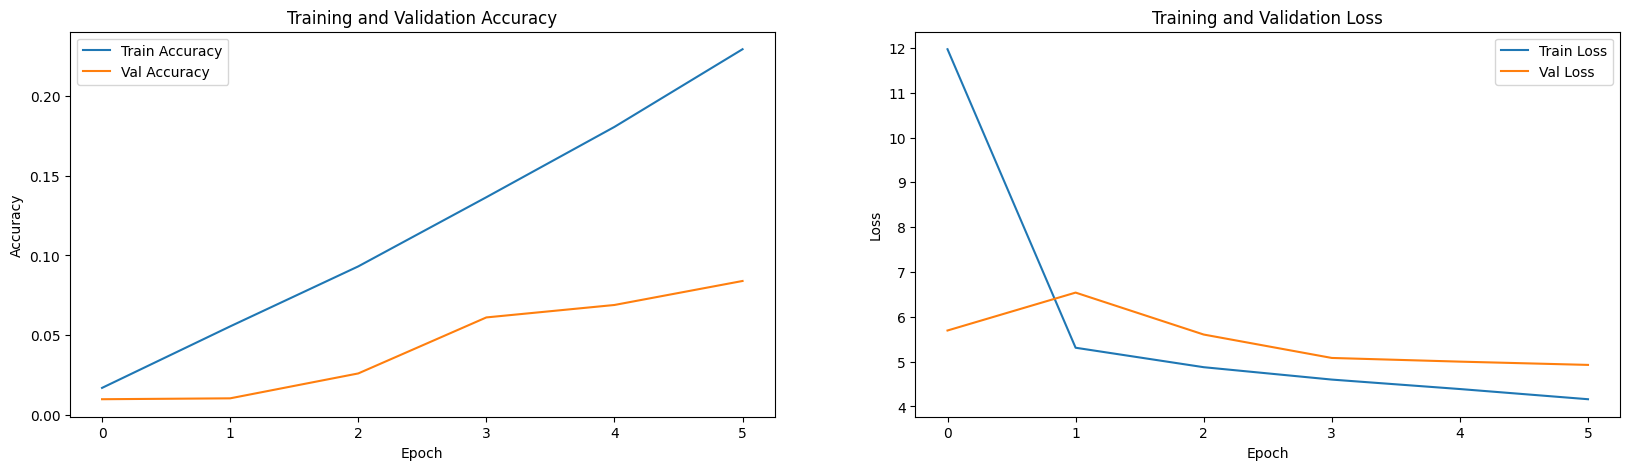

In [ ]:
df_aug = pd.read_csv(root_dir_path / "Model Metrics"/ "model_oversample_paral_aug3.csv")

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(df_aug["accuracy"], label="Train Accuracy")
axes[0].plot(df_aug["val_accuracy"], label="Val Accuracy")
axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

axes[1].plot(df_aug["loss"], label="Train Loss")
axes[1].plot(df_aug["val_loss"], label="Val Loss")
axes[1].set_title("Training and Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

<div class="alert alert-block alert-info"> 

# PRE-TRAINED MODELS

</div>

# RESNET50_CUSTOM

In [ ]:
# build model
resnet_model_2 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# freezing the layers of the base resnet so its not trained
resnet_model_2.trainable = False

# adding more layers
model = tf.keras.Sequential([
    resnet_model_2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

# compiling
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.summary()
epochs = 12

checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min') # usefull to save the best epoch of the model

history = model.fit(
    train_ds_sample_aug,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint_cb]
)

# results
eval_results = model.evaluate(test_ds, return_dict=True, verbose=0)
print(f"Test loss: {eval_results['loss']}, Test accuracy: {eval_results['accuracy']}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 202)            │       207,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,892,938 (98.77 MB)

 Trainable params: 2,305,226 (8.79 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0229 - auc: 0.6080 - f1_score: 0.0025 - loss: 5.3010

105/105 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.0229 - auc: 0.6082 - f1_score: 0.0025 - loss: 5.2997 - val_accuracy: 0.0362 - val_auc: 0.6698 - val_f1_score: 0.0012 - val_loss: 5.0109
Epoch 2/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0288 - auc: 0.6586 - f1_score: 0.0022 - loss: 5.0595

105/105 ━━━━━━━━━━━━━━━━━━━━ 611s 6s/step - accuracy: 0.0288 - auc: 0.6587 - f1_score: 0.0022 - loss: 5.0593 - val_accuracy: 0.0351 - val_auc: 0.6810 - val_f1_score: 0.0015 - val_loss: 4.9768
Epoch 3/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0328 - auc: 0.6681 - f1_score: 0.0024 - loss: 5.0185

105/105 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - accuracy: 0.0328 - auc: 0.6681 - f1_score: 0.0024 - loss: 5.0183 - val_accuracy: 0.0384 - val_auc: 0.6877 - val_f1_score: 0.0020 - val_loss: 4.9347
Epoch 4/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0322 - auc: 0.6803 - f1_score: 0.0023 - loss: 4.9876

105/105 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - accuracy: 0.0322 - auc: 0.6804 - f1_score: 0.0023 - loss: 4.9875 - val_accuracy: 0.0401 - val_auc: 0.6926 - val_f1_score: 0.0021 - val_loss: 4.9137
Epoch 5/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0319 - auc: 0.6817 - f1_score: 0.0024 - loss: 4.9745

105/105 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - accuracy: 0.0319 - auc: 0.6817 - f1_score: 0.0024 - loss: 4.9743 - val_accuracy: 0.0479 - val_auc: 0.6985 - val_f1_score: 0.0027 - val_loss: 4.9068
Epoch 6/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.0363 - auc: 0.6860 - f1_score: 0.0026 - loss: 4.9521 - val_accuracy: 0.0512 - val_auc: 0.6942 - val_f1_score: 0.0025 - val_loss: 4.9145
Epoch 7/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.0338 - auc: 0.6918 - f1_score: 0.0027 - loss: 4.9441

105/105 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - accuracy: 0.0338 - auc: 0.6918 - f1_score: 0.0027 - loss: 4.9439 - val_accuracy: 0.0401 - val_auc: 0.6985 - val_f1_score: 0.0029 - val_loss: 4.8896
Epoch 8/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0368 - auc: 0.6907 - f1_score: 0.0025 - loss: 4.9401

105/105 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.0368 - auc: 0.6907 - f1_score: 0.0025 - loss: 4.9399 - val_accuracy: 0.0395 - val_auc: 0.6982 - val_f1_score: 0.0023 - val_loss: 4.8861
Epoch 9/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0398 - auc: 0.6942 - f1_score: 0.0027 - loss: 4.9248

105/105 ━━━━━━━━━━━━━━━━━━━━ 603s 6s/step - accuracy: 0.0398 - auc: 0.6943 - f1_score: 0.0027 - loss: 4.9247 - val_accuracy: 0.0473 - val_auc: 0.6996 - val_f1_score: 0.0039 - val_loss: 4.8840
Epoch 10/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - accuracy: 0.0402 - auc: 0.6939 - f1_score: 0.0031 - loss: 4.9184 - val_accuracy: 0.0495 - val_auc: 0.6982 - val_f1_score: 0.0033 - val_loss: 4.8942
Epoch 11/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0370 - auc: 0.6957 - f1_score: 0.0029 - loss: 4.9167

105/105 ━━━━━━━━━━━━━━━━━━━━ 607s 6s/step - accuracy: 0.0370 - auc: 0.6957 - f1_score: 0.0029 - loss: 4.9165 - val_accuracy: 0.0434 - val_auc: 0.7070 - val_f1_score: 0.0028 - val_loss: 4.8758
Epoch 12/12
105/105 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - accuracy: 0.0410 - auc: 0.7006 - f1_score: 0.0034 - loss: 4.8997 - val_accuracy: 0.0434 - val_auc: 0.7044 - val_f1_score: 0.0024 - val_loss: 4.8766
Test loss: 4.84375, Test accuracy: 0.04894326999783516


In [ ]:
# finetuning our model by unfreezing the last 10 layers with a lower learning rate to learn more about high-level features

for layer in resnet_model_2.layers[-10:]:
    layer.trainable = True

# compiling the model again
model.compile(optimizer=Adam(learning_rate=0.0001), loss=loss, metrics=metrics)

history_finetune = model.fit(
    train_ds_sample_aug,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

eval_results = model.evaluate(test_ds, return_dict=True, verbose=0)
print(f"Test loss: {eval_results['loss']}, Test accuracy: {eval_results['accuracy']}")

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 684s 6s/step - accuracy: 0.0461 - auc: 0.7037 - f1_score: 0.0038 - loss: 4.9829 - val_accuracy: 0.0345 - val_auc: 0.6852 - val_f1_score: 0.0012 - val_loss: 4.9925
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 657s 6s/step - accuracy: 0.0491 - auc: 0.7083 - f1_score: 0.0065 - loss: 4.8462 - val_accuracy: 0.0390 - val_auc: 0.6941 - val_f1_score: 0.0022 - val_loss: 4.9411
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.0486 - auc: 0.7135 - f1_score: 0.0054 - loss: 4.8197 - val_accuracy: 0.0501 - val_auc: 0.7094 - val_f1_score: 0.0056 - val_loss: 4.8497
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 674s 6s/step - accuracy: 0.0558 - auc: 0.7227 - f1_score: 0.0076 - loss: 4.7786 - val_accuracy: 0.0651 - val_auc: 0.7132 - val_f1_score: 0.0094 - val_loss: 4.8086
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 662s 6s/step - accuracy: 0.0644 - auc: 0.7245 - f1_score: 0.0085 - loss: 4.7558 - val_accuracy: 0.0607 - val_auc: 0.7071 - val_f1_score: 0.0101 - va

# EFFICIENTNETB3_CUSTOM

In [ ]:
# pre-trained model
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # use trained layers

# build
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # reduce dimensionality
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.arange(NUM_CLASSES),
                                     y=train_ds.classes)
class_weights = dict(enumerate(class_weights))

# callbacks
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6)
]


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)


# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 8388 images belonging to 202 classes.
Found 1797 images belonging to 202 classes.
Found 1798 images belonging to 202 classes.


c:\Users\maria\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
 12/263 ━━━━━━━━━━━━━━━━━━━━ 12:14 3s/step - accuracy: 0.0164 - loss: 5.4126

c:\Users\maria\anaconda3\envs\DeepLearning\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - accuracy: 0.0054 - loss: 5.5857 - val_accuracy: 0.0039 - val_loss: 5.3894 - learning_rate: 0.0010
Epoch 2/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - accuracy: 0.0033 - loss: 5.4457 - val_accuracy: 0.0045 - val_loss: 5.3630 - learning_rate: 0.0010
Epoch 3/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.0033 - loss: 5.4381 - val_accuracy: 0.0028 - val_loss: 5.3073 - learning_rate: 0.0010
Epoch 4/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.0039 - loss: 5.4964 - val_accuracy: 0.0067 - val_loss: 5.3089 - learning_rate: 0.0010
Epoch 5/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 799s 3s/step - accuracy: 0.0029 - loss: 5.4114 - val_accuracy: 0.0083 - val_loss: 5.2821 - learning_rate: 0.0010
Epoch 6/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.0047 - loss: 5.3726 - val_accuracy: 0.0067 - val_loss: 5.2623 - learning_rate: 0.0010
Epoch 7/15
263/263 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - accuracy: 0.0034 - loss: 5.4131 - val_

KeyboardInterrupt: 

Due to time constraints output was interrupted as results were improving and insights could already be taken.